In [1]:
import re
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import zscore
import numpy as np

In [2]:
with open("new_dumps.txt") as f:
    buf = f.read()

In [3]:
parts = [p for p in  buf.split("START") if p not in [""]]

In [4]:
def dump_to_tuple(dump):
    
    """
    Converts a raw traceroute data-dump into a summarized tuple.
    """
    
    # timestamp
    lines = [l for l in dump.split("\n") if l not in [ "" ] ]
    timestamp = int( lines[0])
    
    # first line (beside the timestamp)
    l1 = lines[1]
    # last line 
    last = lines[-1]
    
    try:
        ip1 = re.match(".*\((.*)\).*", l1).group(1)
        ip2 = re.match(".*\((.*)\).*", last).group(1)
    except:
        pass
    
    # check if target was reached 
    reached = ip1==ip2!=None
    
    # number of hops
    hops = int(last [:4] )
    
    # target latency (ms)
    try:    
        times = re.findall("\d+.\d+ ms", last)
        times = [float(t.replace("ms", "")) for t in times ]
        latency = sum(times)/len(times)
    except:
        latency = None
    
    return (timestamp, hops, reached, latency)

# Convert dumps to dataframe

In [5]:
tuples = [dump_to_tuple(p) for p in parts]

In [6]:
df = pd.DataFrame(tuples, columns=["timestamp", "hops", "reached", "latency_ms"])

## Re-format timestamp

In [7]:
df["timestamp"] = pd.to_datetime(df.timestamp, unit="s")

In [8]:
df = df.set_index("timestamp")

#### Number of readings:

In [9]:
len(df) 

2204

#### Filter out outliers:

(Removing observations with a very high z-score; ie: a high number of standard deviations from the mean).

In [10]:
df.latency_ms.describe()

count    2204.000000
mean        0.931891
std         1.188018
min         0.249000
25%         0.719375
50%         0.927000
75%         1.071250
max        47.569000
Name: latency_ms, dtype: float64

In [11]:
MAX_ZSCORE = 3

In [12]:
df = df[np.abs( zscore(df.latency_ms)) < MAX_ZSCORE]

## Convert GMT to CEST

(Assuming google.it is most accessed from Italy).

In [13]:
df.index = df.index  + pd.DateOffset(hours=2)

<AxesSubplot:ylabel='Density'>

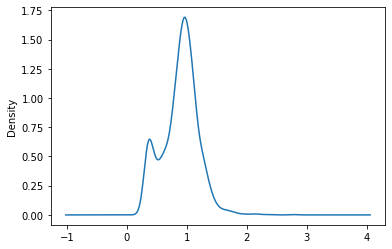

In [14]:
df.latency_ms.plot.kde()

In [15]:
len(df)

2200

In [16]:
df.latency_ms.describe(percentiles=[i/10 for i in range(10)])

count    2200.000000
mean        0.889477
std         0.299264
min         0.249000
0%          0.249000
10%         0.413900
20%         0.628400
30%         0.779000
40%         0.861000
50%         0.926000
60%         0.978000
70%         1.037000
80%         1.107200
90%         1.234067
max         2.790000
Name: latency_ms, dtype: float64

#### Compute mean and standard error of metrics over the hour (0-23)

In [17]:
df["hour"] = df.index.hour

In [18]:
df

,hops,reached,latency_ms,hour
timestamp,,,,
2022-04-17 16:09:56,15,True,0.919000,16
2022-04-17 16:15:01,15,True,0.484667,16
2022-04-17 16:20:06,13,True,0.540333,16
2022-04-17 16:25:11,15,True,0.696000,16
2022-04-17 16:30:16,13,True,0.947000,16
...,...,...,...,...
2022-04-25 10:20:53,13,True,1.024500,10
2022-04-25 10:25:58,12,True,0.981000,10
2022-04-25 10:31:03,12,True,0.834000,10


In [19]:
def period(h):
    if 4 <= h < 11:
        return "MORNING"
    if 11 <= h < 18:
        return "DAY"
    if 18 <=h < 21:
        return "EVENING"
    if  h >= 21  or h < 4:
        return "NIGHT"

In [20]:
df["period"] = df.hour.apply( period )

In [21]:
df.period.value_counts()

NIGHT      661
MORNING    658
DAY        597
EVENING    284
Name: period, dtype: int64

In [22]:
df.groupby("period").latency_ms.mean()

period
DAY        0.870385
EVENING    0.852614
MORNING    0.913451
NIGHT      0.898694
Name: latency_ms, dtype: float64

In [23]:
df.groupby("period").latency_ms.var()

period
DAY        0.088604
EVENING    0.083011
MORNING    0.077587
NIGHT      0.103982
Name: latency_ms, dtype: float64

In [24]:
df2 = df.groupby("hour").mean()
std_errs = df.groupby("hour").std().rename( columns= {"hops":"hops_std_err", "reached":"reached_std_err", "latency_ms":"latency_ms_std_err"} )
df =  df2.merge(std_errs, on="hour")

### Rearrange columns:

In [25]:
df = df[[ "latency_ms", "latency_ms_std_err", "hops", "hops_std_err", "reached", "reached_std_err"  ]]

# Plotting Latency

Text(0.5, 1.0, 'LATENCY VS HOUR OF THE DAY/ GOOGLE.IT')

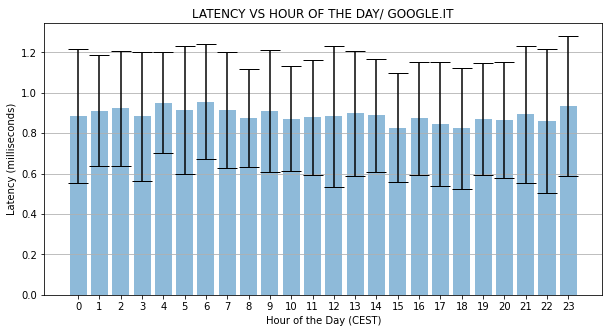

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xticks(df.index)
ax.bar(df.index, df.latency_ms, yerr=df.latency_ms_std_err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.yaxis.grid(True)

ax.set_xlabel('Hour of the Day (CEST)')
ax.set_ylabel('Latency (milliseconds)')
ax.set_title('Latency vs Hour of the Day/ google.it'.upper())


# Plotting Hops

Text(0.5, 1.0, 'NUMBER OF HOPS VS HOUR OF THE DAY/ GOOGLE.IT')

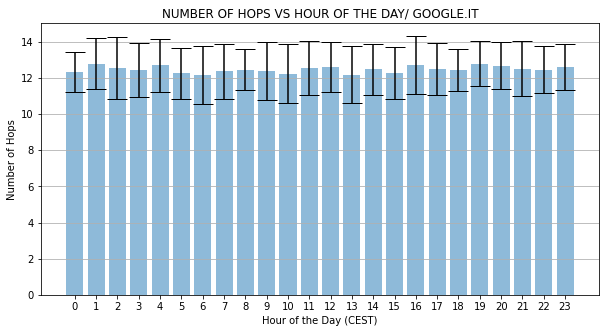

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xticks(df.index)
ax.bar(df.index, df.hops, yerr=df.hops_std_err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.yaxis.grid(True)

ax.set_xlabel('Hour of the Day (CEST)')
ax.set_ylabel('Number of Hops')
ax.set_title('Number of Hops vs Hour of the Day/ google.it'.upper())


In [35]:
df.sort_values(by="latency_ms", ascending=False) [["latency_ms", "latency_ms_std_err"]]

,latency_ms,latency_ms_std_err
hour,,
6,0.955569,0.283697
4,0.951461,0.249570
23,0.933872,0.347573
2,0.923648,0.284790
5,0.915111,0.314960
7,0.914733,0.285439
1,0.911547,0.274709
9,0.909583,0.303091
13,0.897655,0.310639
